# Оценка результатов А/В тестирования изменений, связанных с внедрением улучшенной рекомендательной системы.

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задача" data-toc-modified-id="Задача-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задача</a></span><ul class="toc-item"><li><span><a href="#Техническое-задание" data-toc-modified-id="Техническое-задание-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Техническое задание</a></span></li><li><span><a href="#Данные" data-toc-modified-id="Данные-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Данные</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Описание данных</a></span></li></ul></li><li><span><a href="#Исследуем-данные" data-toc-modified-id="Исследуем-данные-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследуем данные</a></span><ul class="toc-item"><li><span><a href="#Оценим-корректность-проведения-теста." data-toc-modified-id="Оценим-корректность-проведения-теста.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Оценим корректность проведения теста.</a></span></li></ul></li><li><span><a href="#Проведите-исследовательский-анализ-данных" data-toc-modified-id="Проведите-исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проведите исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Распределение-числа-событий-по-дням." data-toc-modified-id="Распределение-числа-событий-по-дням.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Распределение числа событий по дням.</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Оценим-результаты-A/B-тестирования" data-toc-modified-id="Оценим-результаты-A/B-тестирования-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Оценим результаты A/B-тестирования</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>




## Задача

Выяснить влияние изменений, связанных с внедрением улучшенной рекомендательной системы.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    

### Данные

[final_ab_events.csv]

[final_ab_project_marketing_events.csv]

[final_ab_new_users.csv]

[final_ab_participants.csv]

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.



In [1]:
# Загружаем необходимые библиотеки
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime
import math as mth
import numpy as np
from plotly import graph_objects as go


pd.set_option('display.max_colwidth', 150)
#pd.set_option('display.max_rows', 3000)

import warnings
warnings.filterwarnings('ignore')


## Исследуем данные

In [4]:
# загружаю файлы с данными
try:
  events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
  marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
  users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
  participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
finally:
  print('Данные загружены успешно!')

Данные загружены успешно!


In [5]:
# Для вывода общей информации применим функцию info_output
def info_output(data):
 
   print('Информация о датасете')
   display(data.shape)
   print('----------------------------------------------------')
   display(data.info())
   print('----------------------------------------------------')
   print('Первые строки датасета')
   display(data.head())
   print('----------------------------------------------------')
   print('Количество пропусков по столбцам')
   display(data.isna().sum())
   print('----------------------------------------------------')
   print('Количество дубликатов: {0:.0f}'.format(data.duplicated().sum()))
   print('Доля дубликатов: {0:.3%}'.format((data.duplicated().sum()/len(data))))
   print('----------------------------------------------------')
   print('Статистическая информация')
   display(data.describe())




In [6]:
df=[events, marketing_events, users, participants]
df_name=['events', 'marketing_events', 'users', 'participants']
for i, data in enumerate(df):
  print(df_name[i])
  print(' ')
  info_output(data)
  print('------------------------------------------------- ')

events
 
Информация о датасете


(440317, 4)

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

----------------------------------------------------
Первые строки датасета


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


----------------------------------------------------
Количество пропусков по столбцам


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

----------------------------------------------------
Количество дубликатов: 0
Доля дубликатов: 0.000%
----------------------------------------------------
Статистическая информация


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


------------------------------------------------- 
marketing_events
 
Информация о датасете


(14, 4)

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

----------------------------------------------------
Первые строки датасета


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


----------------------------------------------------
Количество пропусков по столбцам


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

----------------------------------------------------
Количество дубликатов: 0
Доля дубликатов: 0.000%
----------------------------------------------------
Статистическая информация


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


------------------------------------------------- 
users
 
Информация о датасете


(61733, 4)

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

----------------------------------------------------
Первые строки датасета


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


----------------------------------------------------
Количество пропусков по столбцам


user_id       0
first_date    0
region        0
device        0
dtype: int64

----------------------------------------------------
Количество дубликатов: 0
Доля дубликатов: 0.000%
----------------------------------------------------
Статистическая информация


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


------------------------------------------------- 
participants
 
Информация о датасете


(18268, 3)

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

----------------------------------------------------
Первые строки датасета


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


----------------------------------------------------
Количество пропусков по столбцам


user_id    0
group      0
ab_test    0
dtype: int64

----------------------------------------------------
Количество дубликатов: 0
Доля дубликатов: 0.000%
----------------------------------------------------
Статистическая информация


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


------------------------------------------------- 


В датасете events 440317 строк и 4 столбца, столбцы user_id, event_dt, event_name в формате object, столбец details в формате float64. Столбец event_dt нужно привести к формату datetime, в столбце details есть 377577 пропущеных значений скорее всего не для всех событий есть дополнительные данные.

В датасете marketing_events 14 строк и 4 столбца.Все столбцы в формате object, столбцы start_dt и finish_dt нужно привести к формату datetime, пропусков в данных нет, дубликатов тоже нет.

В датасете users 61733 строк и 4 столбца, все столбцы в формате object, столбец first_date нужно привести к формату datetime, пропусков в данных нет, дубликатов нет.

В датасете participants 18268 строк и 3 столбца, все столбцы в формате object, пропусков в данных нет, дубликатов нет.



In [7]:
# Приведем столбцы с датой к формату datetime
events['event_dt']= pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')
users['first_date']= pd.to_datetime(users['first_date'], format='%Y-%m-%d')
marketing_events['start_dt']= pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')
marketing_events['finish_dt']= pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')

### Оценим корректность проведения теста.

In [8]:
# Объеденим датасеты users, events и participants
user_new=users.merge(events, on='user_id',how='left').merge(participants, on='user_id', how='left')
user_new.head()


,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,A,recommender_system_test
2,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-07 16:38:09,product_page,NaN,NaN,NaN
3,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-08 02:02:34,product_page,NaN,NaN,NaN
4,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-23 14:35:41,product_page,NaN,NaN,NaN


In [9]:
# Определим временные рамки эксперимента
print('Дата начала эксперимента: {}'.format(user_new['event_dt'].min()))
print('Дата окончания эксперимента: {}'.format(user_new['event_dt'].max()))
print('Продолжительность эксперимента: {}'.format(user_new['event_dt'].max()-user_new['event_dt'].min()))

Дата начала эксперимента: 2020-12-07 00:00:33
Дата окончания эксперимента: 2020-12-30 23:36:33
Продолжительность эксперимента: 23 days 23:36:00


Согласно ТЗ дата остановки теста 2021-01-04, дата последних данных о событиях 2020-12-30, тест должен продолжатся

In [10]:
# посмотрим даты начала набора новых пользователей и даты остановки набора новых пользователей
print('Min дата:',  user_new['first_date'].min())
print('Max дата:',  user_new['first_date'].max())

Min дата: 2020-12-07 00:00:00
Max дата: 2020-12-23 00:00:00


В датасете видим даты от 7 до 23 декабря 2020 года. По ТЗ дата остановки набора новых пользователей - 21 декабря 2020, поэтому удалим из датасета все строки с более поздней датой.

In [11]:
user_new=user_new[user_new['first_date'] <= '2020-12-21']

аудитория: 15% новых пользователей из региона EU
Проверим регионы пользователей.  
Сгруппируем датасет по ```region```



In [12]:
user_new.groupby('region')['user_id'].nunique()

region
APAC          2883
CIS           2900
EU           42340
N.America     8347
Name: user_id, dtype: int64

Видим регионы, отличные от региона "Европа" (N.America, CIS, APAC). Так как для проверки результатов теста нам они не понадобятся, удалим данные по всем регионам, кроме Европы.

In [13]:
user_new = user_new[user_new['region'] == 'EU']

In [14]:
#проверка доли участников теста
print(
    'Доля участников теста относительно общего количества новых пользователей из региона "Европа": {:.2f}%'.format(
        user_new[user_new['ab_test'] == 'recommender_system_test']['user_id'].nunique()/(user_new['user_id'].nunique())*100)
)

Доля участников теста относительно общего количества новых пользователей из региона "Европа": 15.00%


In [15]:
user_new[user_new['region'] == 'EU']['user_id'].nunique()

42340

In [16]:
users[users['region'] == 'EU']['user_id'].nunique()

46270

Согласно ТЗ аудитория 15% новых пользователей из региона EU в нашем тесте набралась.

In [17]:
#оценим группировку значений по тесту и группе теста
user_new.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5342
                        B         5223
recommender_system_test A         3634
                        B         2717

Предоставлены данные о двух тестах  ```interface_eu_test``` и ```recommender_system_test```. Согласно ТЗ нас интересует только ```recommender_system_test``` 

Проверим пересечения тестовых аудиторий. Для этого создадим датасет, в котором сохраним количество тестов, в которых принимал участие каждый пользователь и присоеденим его к датасету user_new.




In [18]:
#создадим датафрейм, в котором сохраним количество тестов, в которых принимал участие каждый пользователь
two_tests_user_new = user_new.groupby('user_id', as_index=False).agg({'ab_test': 'nunique'})
two_tests_user_new = two_tests_user_new.rename(columns={'ab_test': 'number_of_tests'})
user_new=user_new.merge(two_tests_user_new, on = 'user_id', how='left')

Оставим в датасете user_new данные только для интересующего нас теста и проверим количество уникальных групп теста.

In [19]:
user_new=user_new[user_new['ab_test']=='recommender_system_test']
user_new.groupby(['number_of_tests']).agg({'user_id': 'nunique'})


,user_id
number_of_tests,
1,4749
2,1602


Проверю вхождение в группы нашего теста пользователей, принимавших участие в тесте  ```interface_eu_test```

In [20]:
user_new.groupby(['group', 'number_of_tests']).agg({'user_id': 'nunique'})

user_id
group number_of_tests         
A     1                   2713
      2                    921
B     1                   2036
      2                    681

Принимали участие в обоих тестах из группы А 921 человек, из группы В 681 человек.

In [21]:
users_dubl = user_new.groupby(['user_id']).agg({'group': 'nunique'})
users_dubl[users_dubl['group']>1]

,group
user_id,


In [22]:
user_new.groupby(['group']).agg({'user_id': 'nunique'})

,user_id
group,
A,3634
B,2717


Пользователей, принявших участие в  ```recommender_system_test```  6351, что соответствует ТЗ. Участники по группам распределены не равномерно, в гуппе А - 3634 участника, в группе В - 2717 участников, что не очень хорошо для корректного проведения теста.  
 1602 участника принимали участие и в тесте ```interface_eu_test``` не буду их удалять, участие в двух тестах не влияет на результат так как снижение мощности теста (уменьшение количества участников), 4749 участников сильно не дотягивает до необходимого по ТЗ.
 Пеесечений пользователей между гуппами нет.




Проверим значения в столбце ```details```



In [23]:
user_new.groupby('event_name', as_index=False).agg({'details': 'count'})

,event_name,details
0,login,0
1,product_cart,0
2,product_page,0
3,purchase,3196


В столбце details присутствуют не все значения, так как в нем указана сумма покупки, поэтому данные есть только в событиях типа "purchase" (транзакциях, зафиксировавших факт покупки), что вполне логично. Пропуски трогать не будем.

In [24]:
ab_events = events[events['user_id'].isin(user_new['user_id'])]
print('Количество событий, совершенных пользователями, входящими в выборку нашего теста:', ab_events.count())

Количество событий, совершенных пользователями, входящими в выборку нашего теста: user_id       23420
event_dt      23420
event_name    23420
details        3196
dtype: int64


In [25]:
print('Количество уникальных идентификаторов пользователей в таблице событий:', ab_events['user_id'].nunique())
print('Доля уникальных идентификаторов пользователей в таблице событий: {:.2%}'.format(1-(user_new[user_new['event_name'].isna()]['user_id'].nunique()/user_new['user_id'].nunique())))


Количество уникальных идентификаторов пользователей в таблице событий: 3481
Доля уникальных идентификаторов пользователей в таблице событий: 54.81%


Только 55% пользователей очищенной выборки генерировали события в заданный период. Есть вероятность, что произошла ошибка учета активности пользователей, либо возникла проблема в процессе выгрузки данных

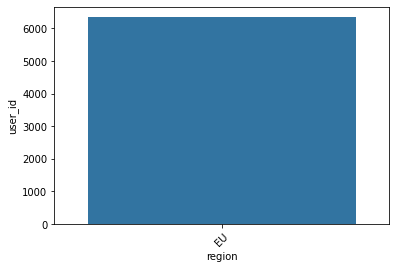

In [26]:
user_region=user_new.groupby('region')['user_id'].nunique().reset_index()
sns.barplot(user_region['region'], user_region['user_id'])
plt.xticks(rotation=45);

Все пользователи из нужного нам региона EU.

## Проведите исследовательский анализ данных

Рассчитаем среднее количество событий на каждого пользователа по группам А и В.

In [27]:
#расчитаем среднее количество событий на каждого пользователа по группам А и В
event_by_user_id = user_new.groupby(['user_id', 'group'])['event_name'].count().reset_index()
event_by_user_id = event_by_user_id[event_by_user_id['event_name']!=0]

print('Среднее количество событий на пользователя в группе А: {:.0f}' \
                              .format(event_by_user_id.query('group == "A"')['event_name'].mean()))
print('Среднее количество событий на пользователя в группе B: {:.0f}' \
                                .format(event_by_user_id.query('group == "B"')['event_name'].mean()))

Среднее количество событий на пользователя в группе А: 7
Среднее количество событий на пользователя в группе B: 6


##Изменение конверсии в воронке на разных этапах
Построим сводную таблицу по группам и оценим цифры конверсии из события в событие.

In [28]:
user_total = user_new['user_id'].nunique()
events_users = user_new.pivot_table(
    index='event_name',
    columns='group',
    values='user_id',
    aggfunc='nunique'
).reindex(["login", "product_page", "product_cart", "purchase"]) #с помощью reindex расположим события в нужном порядке

events_users['total'] = events_users.sum(axis=1)
events_users['share'] = (events_users['total']/user_total)*100
events_users=events_users.reset_index()
events_users

group,event_name,A,B,total,share
0,login,2604,877,3481,54.810266
1,product_page,1685,493,2178,34.293812
2,product_cart,782,244,1026,16.154936
3,purchase,833,249,1082,17.036687


Всего 4 варианта событий:

login - регистрация пользователя  
product_page - посещение страницы с товаром  
product_cart - добавление товара в корзину  
purchase - заказ  
Видим, что некоторые пользователи делают заказ, минуя шаг "добавление заказа в корзину", так как на этом шаге транзакций меньше, чем на шаге "заказ". Вероятно, на сайте можно купить товар сразу, не добавляя его в корзину.

Визуализируем воронку конверсий.

In [29]:
groups=['A', 'B']
fig = go.Figure()
for group in groups:
  fig.add_trace(go.Funnel(
      name = group,
      orientation = "h",
      y = events_users['event_name'],
      x=events_users[group],
      textinfo = "value+percent previous+percent initial"
    )
  )

fig.update_layout(title={
        'text': "Продуктовая воронка с конверсией к предыдущему шагу",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show() 

Больше всего пользователей теряется между этапами product_page и product_cart.

In [30]:
print('Конверсия пользователей в покупки в группе А составляет: {:.2f}%'.format(events_users.loc[3,'A']/events_users.loc[0,'A']*100))

print('Конверсия пользователей в покупки в группе B составляет: {:.2f}%'.format(events_users.loc[3,'B']/events_users.loc[0,'B']*100))

print('Отношение конверсии в покупки в группе В к группе А: {:.2f}%'.format((events_users.loc[3,'B']/events_users.loc[0,'B'])/(events_users.loc[3,'A']/events_users.loc[0,'A'])*100))

Конверсия пользователей в покупки в группе А составляет: 31.99%
Конверсия пользователей в покупки в группе B составляет: 28.39%
Отношение конверсии в покупки в группе В к группе А: 88.76%


Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%. Судя по полученным результатам, улучшения нет.

### Распределение числа событий по дням.
Проверим, что тест не совпадает с маркетинговыми и другими активностями.

In [31]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [32]:
marketing_events[
    (marketing_events['start_dt'] >= '2020-11-30') & (
        marketing_events['start_dt'] <= '2021-01-04')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Для региона EU подходит событие Christmas&New Year Promo, оно же имеет сильное пересечение с периодом теста.

Этот факт дополнительно может неблагоприятно повлиять на результаты теста.

Посмотрим на распределение событий по датам.

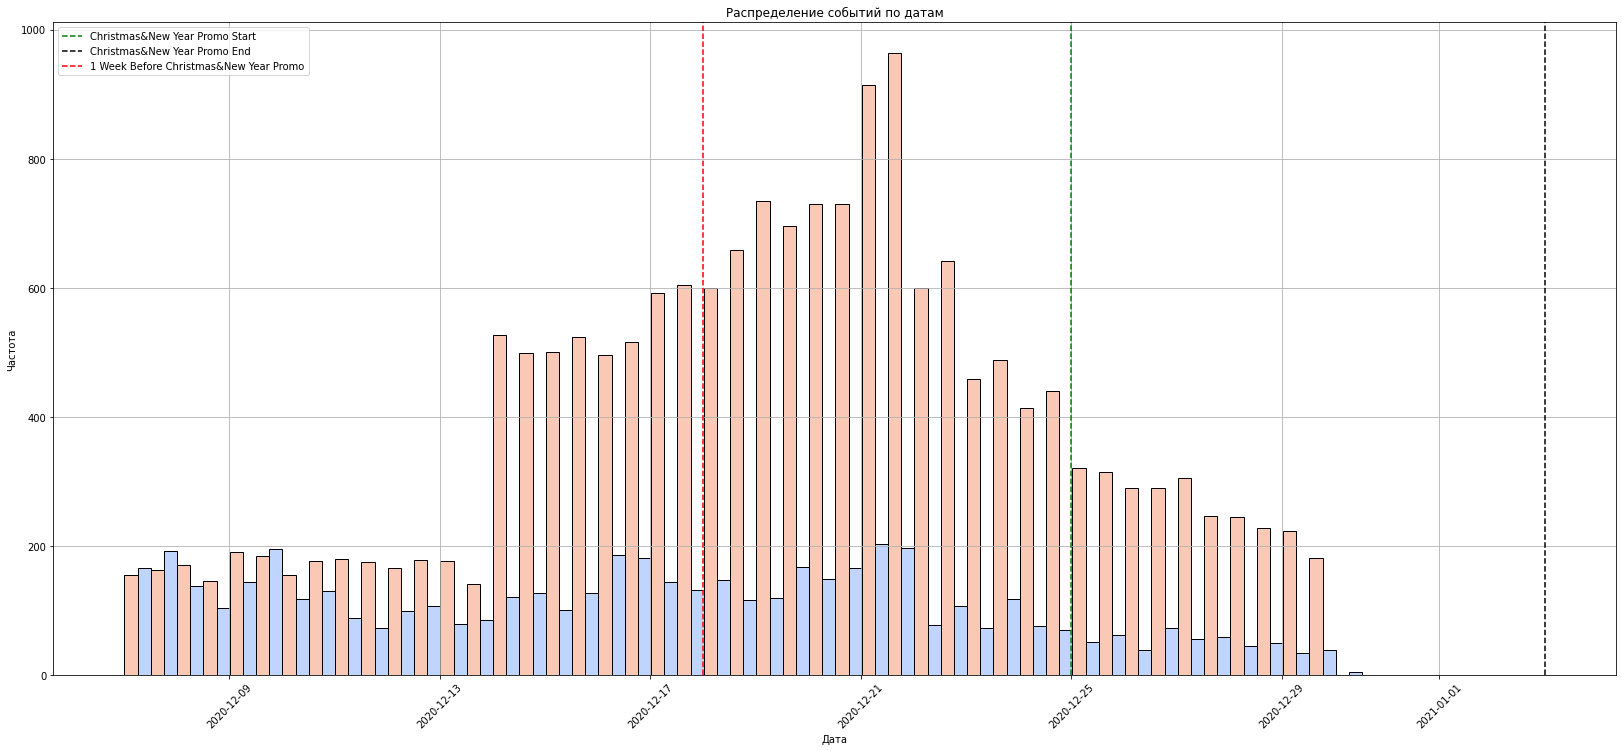

In [33]:
plt.figure(figsize =(28,12))
sns.histplot(data=user_new, x=user_new['event_dt'], hue = 'group', multiple="dodge", palette = 'coolwarm_r')

plt.axvline(x=datetime.strptime('2020-12-25', '%Y-%m-%d'), color='green', linestyle='--', label='Christmas&New Year Promo Start')
plt.axvline(x=datetime.strptime('2021-01-03', '%Y-%m-%d'), color='black', linestyle='--', label='Christmas&New Year Promo End')
plt.axvline(x=datetime.strptime('2020-12-18', '%Y-%m-%d'), color='red', linestyle='--', label='1 Week Before Christmas&New Year Promo')
plt.title('Распределение событий по датам')
plt.legend()
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)
plt.show()

В контрольной группе А примерно больше событий, чем в 
тестируемой группе В. Это произошло из-за резкого всплеска с 14 декабря в группе А (больше 600 собыий), который после 21 декабря медленно пошел на спад. Максимальное количество событий произошло для группы А 21 декабря (больше 1200). В группе В сильного всплеска активности не наблюдается.

### Вывод
События в рамках теста имеют сильное пересечение с рождественской маркетинговой активностью. Пик продаж в предпраздничные дни. Выбор этих дат для теста может неблагоприятно повлиять на результаты теста. Количество событий на пользователя распределены неравномерно в выборках. В группе А - 7 событий, в группе В - 6 событий.

Воронка состоит из 4х этапов:

login - пользователь зашел на сайт,  
product_page - просмотрел товар,  
product_cart - попал в корзину,  
purchase - совершил покупку.  
Количество пользователей, совершивших покупку, больше, чем количествово пользователей, попавших в корзину - вероятно, это связано с тем, что часть пользователей совершили покупку, минуя корзину.

Больше всего пользователей теряется между этапами product_page и product_cart (54% для группы А и 51% для группы Б).

## Оценим результаты A/B-тестирования


Сформулируем нулевую гипотезу Н0:  
Доли пользователей групп А и В на каждом шаге воронки равны.  

Альтернативная гипотеза Н1:  
Доли пользователей групп А и В на каждом шаге воронки не равны.

Для сравнения долей будем использовать Z-тест. Z-тест – это статистический тест, позволяющий определить, различаются ли два средних значения генеральной совокупности.


Посчитаем число пользователей и долю пользователей в каждой группее, совершивших каждое событие. Проверим отличие между группам. Для этого напишем функцию test_stat, на вход которой передадим необходимый датасет, названия групп и уровень статистической значимости.

In [34]:
def test_stat(df, groups_1, groups_2, alpha):
  # датасет сгруппируем по названию событий, посчитаем уникальное число пользователей.
  df_full_stat = df.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
  users=[df_full_stat.loc[0,groups_1], df_full_stat.loc[0,groups_2]]
  df_full_stat=df_full_stat.loc[1:].reset_index(drop=True)
  # циклом создадим список числа уникальных пользователей для каждого события по группам.
  for i, event in enumerate (df_full_stat['event_name']):
    events = [df_full_stat.loc[i,groups_1], df_full_stat.loc[i,groups_2]]
    #print(events) # проверка
    #print(i) # проверка
    p1 = events[0] / users[0] # считаем долю для 1 группы
    p2 = events[1] / users[1] # считаем долю для 2 группы
    p_combined = sum(events) / sum(users)
    difference = p1 - p2 # разница в датасетах
    z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]) #считаем z-value, которая покажет, насколько она далека от среднего значения точки данных
    )
    distr = st.norm(0, 1) # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2 # считаем p-value
        
    print(event)
    print('Доля пользователей группы %s: {0:.2f}'.format(p1)% (groups_1))
    print('Доля пользователей группы %s: {0:.2f}'.format(p2)% (groups_2))
    print('p-значение: ', p_value)
    # сравниваем p-value и alpha
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу по событию %s: между долями есть значимая разница' % (event))
    else:
        print('Не получилось отвергнуть нулевую гипотезу по событию %s: нет оснований считать доли разными' % (event))
            
    print('-------------------------------')
    print(' ')

In [35]:
test_stat(user_new, 'A', 'B', 0.05)

product_cart
Доля пользователей группы A: 0.30
Доля пользователей группы B: 0.28
p-значение:  0.21469192029582396
Не получилось отвергнуть нулевую гипотезу по событию product_cart: нет оснований считать доли разными
-------------------------------
 
product_page
Доля пользователей группы A: 0.65
Доля пользователей группы B: 0.56
p-значение:  6.942739359416805e-06
Отвергаем нулевую гипотезу по событию product_page: между долями есть значимая разница
-------------------------------
 
purchase
Доля пользователей группы A: 0.32
Доля пользователей группы B: 0.28
p-значение:  0.04652482738393027
Отвергаем нулевую гипотезу по событию purchase: между долями есть значимая разница
-------------------------------
 


Одну и ту же гипотезу мы тестируем в разных вариациях. Важная особенность множественного теста в том, что вероятность ошибки первого рода увеличивается с каждой новой проверкой гипотезы.

Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим метод Бонферони. Для этого поделим принятый уровень значимости (0.05) на число сравнений (4), которые проводят на одних и тех же данных, без сбора новых наблюдений для каждого теста.

Всего 3 варианта - 3 события. С учетом поправки, альфа будет равна 0.05/3 = 0.017.

Сравним группы с новым уровнем статистической значимости.

In [36]:
test_stat(user_new, 'A', 'B', 0.017)

product_cart
Доля пользователей группы A: 0.30
Доля пользователей группы B: 0.28
p-значение:  0.21469192029582396
Не получилось отвергнуть нулевую гипотезу по событию product_cart: нет оснований считать доли разными
-------------------------------
 
product_page
Доля пользователей группы A: 0.65
Доля пользователей группы B: 0.56
p-значение:  6.942739359416805e-06
Отвергаем нулевую гипотезу по событию product_page: между долями есть значимая разница
-------------------------------
 
purchase
Доля пользователей группы A: 0.32
Доля пользователей группы B: 0.28
p-значение:  0.04652482738393027
Не получилось отвергнуть нулевую гипотезу по событию purchase: нет оснований считать доли разными
-------------------------------
 


Для события login проверка статистической разницы долей z-критерием невозможна, так как это действие совершили все пользователи группы А и группы В, совершившие события.

Различие между экспериментальной группой В и контрольной А для событий "Просмотр карточек товаров" и "Покупка" статистически значимо (p-value < 0.05).

Видим, что различие между экспериментальной группой В и контрольной А для события на этапах "Просмотр корзины" статистически не значимо. Высокое p-value (выше критерия значимости 0.05) обозначает, что мы имеем высокую вероятность случайных различий между показателями, обусловленных обычной дисперсий/вариацией в данных, а не реальной разницей.


При применении поправки Бонферони Различия между экспеиментальной группой В и контрольной А для событий "Покупка" стало статистически не значимо, что указывает на вероятность ложнопозитивного результата при савнении групп на этапе "Покупка"

## Вывод
Согласно ТЗ за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%. Улучшения не произошло. Различия между группами A и B на этапе "Авторизация" -> "Просмотр карточек товаров" статистически не значимы, на этапах "Просмотр карточек товаров" -> "Просмотр корзины" и "Просмотр корзины" -> "Покупка" статистически значимо, но при применении поправки Бонферони различия в группах на этапе "Просмотр корзины" -> "Покупка" становятся статистически незначимы. Это может говорить о том, что различия между группами поличились случайно. 

Конверсия группы А больше конверсии группы В.

## Общий вывод

Согласно ТЗ окончание теста назначено на  2021-01-04 самая поздняя дата в предоставленных данных 2020-12-30.
Последняя дата регистрации новых пользователей заявленная-  2020-12-21 в данных 2020-12-23.
Также присутствуют пересечения тестовой аудитории между тестами, что при очистке и приведению к требованиям ТЗ значительно снижает мощность теста. Нам не известно время проведения дугого теста, и пересекается ли он по времени и действиям с целевым тестом. Поэтому мы включили этих пользователей в наше исследование.

Тест проводили во время рождественской маркетинговой активности, что в значительной мере повлияло на результаты теста.  
Только 55% выборки совершали события, что возможно стало результатом некоректной выгрузки данных или низкой заинтересованностью пользователей при ознакомлении с сайтом.  
Пользователи по группам распределены неравномерно, что также влияет на результат теста не  лучшую сторону.  

Пользовател проходит 4 шага:  
* login - регистрация пользователя
* product_page - посещение страницы с товаром
* product_cart - добавление товара в корзину
* purchase - покупка   
Но в покупку можно совершить со страницы с товаром, минуя корзину.

Конверсия заегистрировавшихся пользователей в покупки группы А составляет: 31.99% Конверсия заегистрировавшихся пользователей в покупки группы B составляет: 28.39%

По результатам А/В теста можно сделать следущие выводы:
* Доля пользователей сконвертировашихся в шаг "посещение страницы с товаром" группы В меньше доли таких же ползователей группы А
* Доля пользователей сконвертировашихся в шаг "добавление товара в корзину" в обоих группах не имеют статистически значимых различий
* Доля пользователей сконвертировашихся в шаг "покупка" при уровне статистической значимости  0,017 (с поправкой Бонефеони) в обоих группах не имеют статистически значимых различий, хотя при уровне статистической значимости 0,05 доли групп имели статистически значимые различия.

В целом тест нельзя признать успешным. Необходимо более тщательно подойти к формированию групп теста и выбрать время его проведения без влияния внешних маркетинговых факторов. 
